In [ ]:
import jax
import neos.makers as makers
import neos.cls as cls
import numpy as np
import jax.experimental.stax as stax
import jax.experimental.optimizers as optimizers
import jax.random
import time

In [ ]:
init_random_params, predict = stax.serial(
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1),
    stax.Sigmoid
)

In [ ]:
bins = np.linspace(0,1,11)
centers   = bins[:-1]  + np.diff(bins)/2.
bandwidth = .7 * 1/(len(bins)-1)

hmaker = makers.kde_counts_from_nn_three_blobs(predict,bins=bins,bandwidth=bandwidth)
nnm = makers.nn_hepdata_like(hmaker)
loss = cls.cls_maker(nnm, solver_kwargs=dict(pdf_transform=True))

### Randomly initialise nn weights and check that we can get the gradient of the loss wrt nn params

In [ ]:
gradd = jax.jit(jax.value_and_grad(loss))
_, network = init_random_params(jax.random.PRNGKey(2), (-1, 2))
gradd(network, 1.0)

/Users/phinate/envs/neos/lib/python3.7/site-packages/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Traced<ShapedArray(float64[10])>with<JVPTrace(level=1/2)> Traced<ShapedArray(float64[10])>with<JVPTrace(level=1/2)> Traced<ShapedArray(float64[10])>with<JVPTrace(level=1/2)>
Traced<ShapedArray(float64[10]):JaxprTrace(level=2/2)> Traced<ShapedArray(float64[10]):JaxprTrace(level=2/2)> Traced<ShapedArray(float64[10]):JaxprTrace(level=2/2)>
Traced<ShapedArray(float64[10]):JaxprTrace(level=2/2)> Traced<ShapedArray(float64[10]):JaxprTrace(level=2/2)> Traced<ShapedArray(float64[10]):JaxprTrace(level=2/2)>
Traced<ShapedArray(float64[10])>with<JVPTrace(level=4/2)> Traced<ShapedArray(float64[10])>with<JVPTrace(level=4/2)> Traced<ShapedArray(float64[10])>with<JVPTrace(level=4/2)>


(DeviceArray(nan, dtype=float64),
 [(DeviceArray([[nan, nan, nan, ..., nan, nan, nan],
                [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
   DeviceArray([nan, nan, nan, ..., nan, nan, nan], dtype=float32)),
  (),
  (DeviceArray([[nan, nan, nan, ..., nan, nan, nan],
                [nan, nan, nan, ..., nan, nan, nan],
                [nan, nan, nan, ..., nan, nan, nan],
                ...,
                [nan, nan, nan, ..., nan, nan, nan],
                [nan, nan, nan, ..., nan, nan, nan],
                [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
   DeviceArray([nan, nan, nan, ..., nan, nan, nan], dtype=float32)),
  (),
  (DeviceArray([[nan],
                [nan],
                [nan],
                ...,
                [nan],
                [nan],
                [nan]], dtype=float32),
   DeviceArray([nan], dtype=float32)),
  ()])

### Define training loop!

In [ ]:
#jit_loss = jax.jit(loss)

opt_init, opt_update, opt_params = optimizers.adam(3e-3)

#@jax.jit
def update_and_value(i, opt_state, mu):
    net = opt_params(opt_state)
    value, grad = jax.value_and_grad(loss)(net, mu)
    return opt_update(i, grad, state), value, net

def train_network(N):
    cls_vals = []
    _, network = init_random_params(jax.random.PRNGKey(1), (-1, 2))
    state = opt_init(network)
    losses = []
    
    # parameter update function
    #@jax.jit
    def update_and_value(i, opt_state, mu):
        net = opt_params(opt_state)
        value, grad = jax.value_and_grad(loss)(net, mu)
        return opt_update(i, grad, state), value, net
    
    for i in range(N):
        start_time = time.time()
        state, value, network = update_and_value(i,state,1.0)
        epoch_time = time.time() - start_time
        losses.append(value)
        metrics = {"loss": losses}
        yield network, metrics, epoch_time

### Plotting helper function for awesome animations :)

In [ ]:
def plot(axarr, network, metrics, hm, maxN):
    ax = axarr[0]
    g = np.mgrid[-5:5:101j, -5:5:101j]
    levels = bins
    ax.contourf(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, 1)[:, :, 0],
        levels=levels,
        cmap="BrBG",
    )
    ax.contour(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, 1)[:, :, 0],
        colors="w",
        levels=levels,
    )
    ax.scatter(hm.sig[:, 0], hm.sig[:, 1], alpha=0.25, c="C9", label="sig")
    ax.scatter(hm.bkg1[:, 0], hm.bkg1[:, 1], alpha=0.17, c="C1", label="bkg1")
    ax.scatter(hm.bkg2[:, 0], hm.bkg2[:, 1], alpha=0.17, c="C1", label="bkg2")
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    ax = axarr[1]
    ax.axhline(0.05, c="slategray", linestyle="--")
    ax.plot(metrics["loss"], c="steelblue", linewidth=2.0)

    ax.set_ylim(0, 0.6)
    ax.set_xlim(0, maxN)
    ax.set_xlabel("epoch")
    ax.set_ylabel(r"$cl_s$")

    ax = axarr[2]
    nn = s, b, db = hm(network)
    bin_width = 1/(len(bins)-1)
    ax.bar(centers, b, color="C1", label="bkg",width=bin_width)
    ax.bar(centers, s, bottom=b, color="C9", label="sig",width=bin_width)
    ax.bar(centers, db, bottom=b - db / 2.0, alpha=0.4, color="black", label="bkg error",width=bin_width)
    ax.set_ylim(0, 100)
    ax.set_ylabel("frequency")
    ax.set_xlabel("nn output")

### Let's run it!!

Traced<ShapedArray(float64[10])>with<JVPTrace(level=1/1)> Traced<ShapedArray(float64[10])>with<JVPTrace(level=1/1)> Traced<ShapedArray(float64[10])>with<JVPTrace(level=1/1)>
Traced<ShapedArray(float64[10]):JaxprTrace(level=2/1)> Traced<ShapedArray(float64[10]):JaxprTrace(level=2/1)> Traced<ShapedArray(float64[10]):JaxprTrace(level=2/1)>
Traced<ShapedArray(float64[10]):JaxprTrace(level=2/1)> Traced<ShapedArray(float64[10]):JaxprTrace(level=2/1)> Traced<ShapedArray(float64[10]):JaxprTrace(level=2/1)>
Traced<ShapedArray(float64[10])>with<JVPTrace(level=4/1)> Traced<ShapedArray(float64[10])>with<JVPTrace(level=4/1)> Traced<ShapedArray(float64[10])>with<JVPTrace(level=4/1)>
epoch 0: CLs = nan, took 9.425021886825562s
epoch 1: CLs = nan, took 0.2898380756378174s


/Users/phinate/envs/neos/lib/python3.7/site-packages/matplotlib-3.2.0-py3.7-macosx-10.15-x86_64.egg/matplotlib/contour.py:1483: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/phinate/envs/neos/lib/python3.7/site-packages/matplotlib-3.2.0-py3.7-macosx-10.15-x86_64.egg/matplotlib/contour.py:1484: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/Users/phinate/envs/neos/lib/python3.7/site-packages/matplotlib-3.2.0-py3.7-macosx-10.15-x86_64.egg/matplotlib/contour.py:1163: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
/Users/phinate/envs/neos/lib/python3.7/site-packages/matplotlib-3.2.0-py3.7-macosx-10.15-x86_64.egg/matplotlib/contour.py:1163: RuntimeWarning: invalid value encountered in less
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
/Users/phinate/envs/neos/lib/python3.7/site-packages/ipykernel_launcher.py:17: Us

epoch 2: CLs = nan, took 0.30017518997192383s


KeyboardInterrupt: 

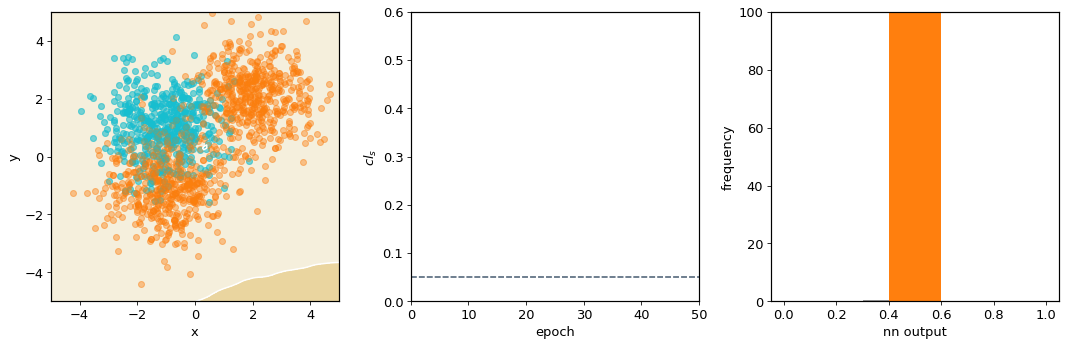

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from celluloid import Camera
from IPython.display import HTML

plt.rcParams.update(
    {
        "axes.labelsize": 13,
        "axes.linewidth": 1.2,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "figure.figsize": [7.2, 3.0],
        "font.size": 13,
        "xtick.major.size": 4,
        "ytick.major.size": 4,
        "legend.fontsize": 11,
    }
)


fig, axarr = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
camera = Camera(fig)

maxN = 50 # make me bigger for better results!

animate = True # animations fail tests

# Training
for i, (network, metrics, epoch_time) in enumerate(train_network(maxN)):
    print(f"epoch {i}:", f'CLs = {metrics["loss"][-1]}, took {epoch_time}s')
    if animate:
        plot(axarr, network, metrics, nnm.hm, maxN=maxN)
        plt.tight_layout()
        camera.snap()
        if i % 10 == 0:
            camera.animate().save("animation.gif", writer="imagemagick", fps=8)
            #HTML(camera.animate().to_html5_video())
if animate:
    camera.animate().save("animation.gif", writer="imagemagick", fps=8)